![Clase aprendizaje no supervisado](https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/taller_4/main/figs/taller-meca-aprendizaje%20no%20supervisado_banner%201169%20x%20200%20px%20-05.png)

# Caso-taller:  Analizando el Delito en Chicago

En este caso-taller vamos a utilizar datos geográficos y estimación de densidad de kernel para analizar delitos en Chicago. Esta ciudad es muy famosa no sólo por haber sido el hogar del mafioso Al Capone, sino también por sus altas tasas de delitos.

Para este taller obtuve datos del portal de la [ciudad de Chicago](https://www.chicago.gov/city/en/dataset/crime.html). La base de datos fue traducida y modificada para nuestras necesidades. Esta contiene todos los homicidios y robos que sucedieron entre el 1 de junio y el 31 de agosto de 2019.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos

#### 1.1. Delitos

En la carpeta `data` se encuentra el archivo `Chicago_delitos_verano_2019.csv` cargue estos datos en su *cuaderno*. Describa brevemente el contenido de la base.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore")
from sklearn.datasets import make_blobs
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import MarkerCluster
import geopandas as gpd

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [2]:
chicago = pd.read_csv('https://raw.githubusercontent.com/sebastian23escobar/Aprendizaje_no_supervisado/refs/heads/main/Taller4/data/Chicago_delitos_verano_2019.csv')
chicago

,fecha,tipo_crimen,nro_area_comunitaria,lat,lon
0,2019-06-01T05:07:00Z,homicidio,23,41.897950,-87.728625
1,2019-06-01T10:09:00Z,homicidio,71,41.753272,-87.648963
2,2019-06-01T12:46:00Z,homicidio,25,41.877622,-87.750728
3,2019-06-01T11:35:00Z,homicidio,16,41.960145,-87.699654
4,2019-06-02T09:39:00Z,homicidio,37,41.804773,-87.633256
...,...,...,...,...,...
17742,2019-08-20T18:00:00Z,robo,77,41.980874,-87.659992
17743,2019-06-20T17:00:00Z,robo,77,41.987182,-87.666804
17744,2019-08-01T05:01:00Z,robo,25,41.890446,-87.757887
17745,2019-08-19T05:01:00Z,robo,8,41.904537,-87.634504


In [3]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17747 entries, 0 to 17746
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fecha                 17747 non-null  object 
 1   tipo_crimen           17747 non-null  object 
 2   nro_area_comunitaria  17747 non-null  int64  
 3   lat                   17747 non-null  float64
 4   lon                   17747 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 693.4+ KB


In [4]:
# convertir fecha a formato fecha
chicago['fecha'] = pd.to_datetime(chicago['fecha'])

In [5]:
chicago['tipo_crimen'].unique()

array(['homicidio', 'robo'], dtype=object)

In [6]:
# crear una serie de tiempo
serie_tiempo = chicago.groupby(['fecha', 'tipo_crimen']).size().reset_index(name = 'conteo')

# filtrar serie de tiempo por robos
robos = serie_tiempo[serie_tiempo['tipo_crimen'] == 'robo']
# filtrar serie de tiempo por homicidios
homicidios = serie_tiempo[serie_tiempo['tipo_crimen'] == 'homicidio']

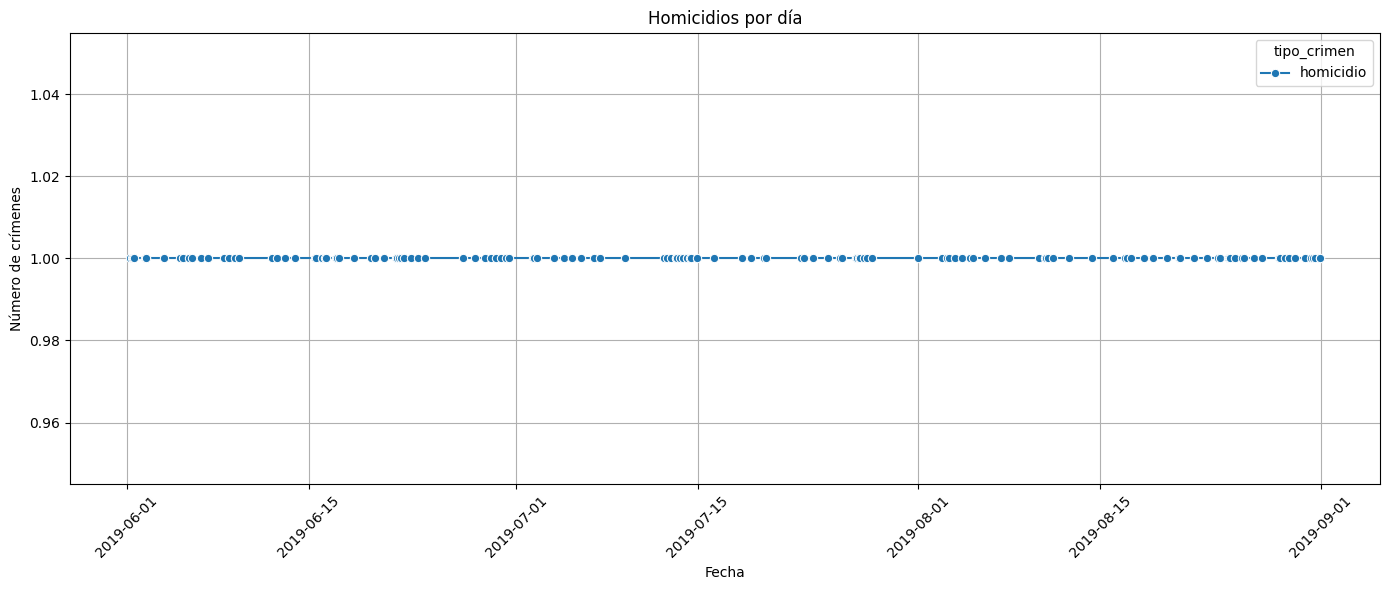

In [7]:
plt.figure(figsize = (14,6))
sns.lineplot(data = homicidios, x = 'fecha', y = 'conteo', hue = 'tipo_crimen', marker = 'o')
plt.title('Homicidios por día')
plt.xlabel('Fecha')
plt.ylabel('Número de crímenes')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [8]:
homicidios['conteo'].describe()

,conteo
count,144.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


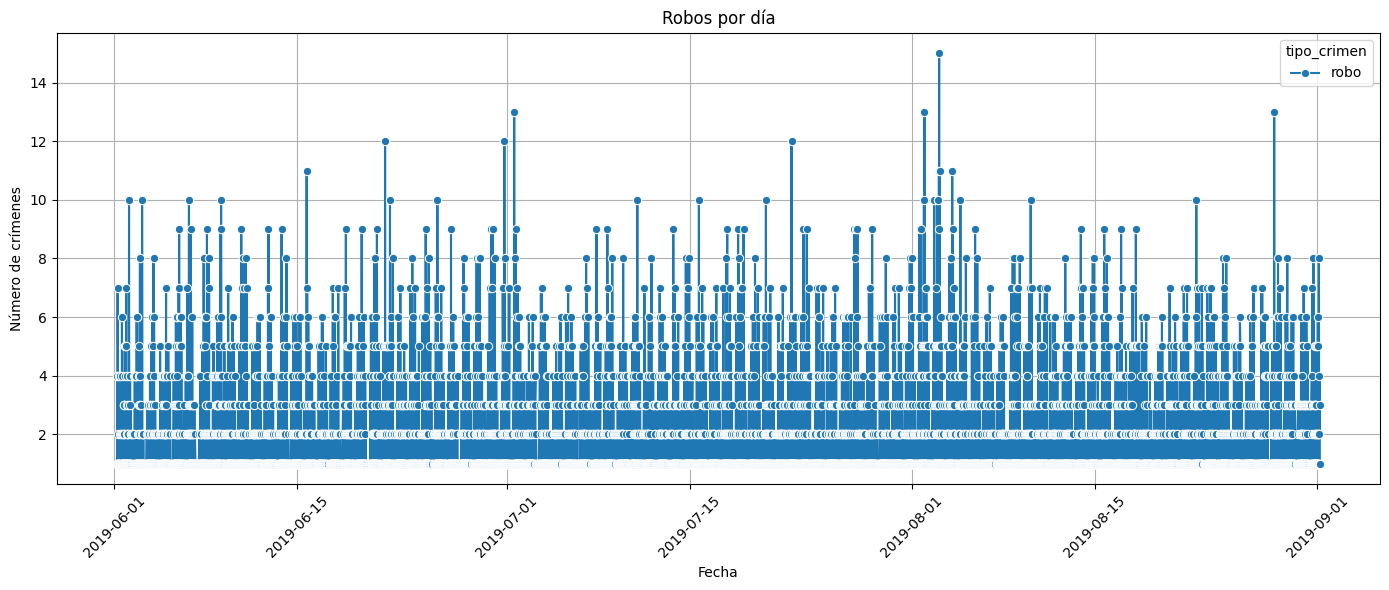

In [9]:
plt.figure(figsize = (14,6))
sns.lineplot(data = robos, x = 'fecha', y = 'conteo', hue = 'tipo_crimen', marker = 'o')
plt.title('Robos por día')
plt.xlabel('Fecha')
plt.ylabel('Número de crímenes')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [10]:
robos['conteo'].describe()

,conteo
count,10088.000000
mean,1.744944
std,1.490286
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


In [11]:
print(len(robos))
print(len(homicidios))

10088
144


A partir de los datos encontramos que los homicidios tienen una frecuencia máxima de 1 y es posible apreciar, por la gráfica, que este tipo de delitos es recurrente en la ciudad. Concretamente, los datos describen 144 homicidios. Por su parte, los tobos son un delito más común que, en nuestros datos, ha tenido un máximo histórico de 15 robos en un día en 1088 observaciones díarias.

#### 1.2. Barrios de Chicago

También en la carpeta `data` se encuentran los archivos con los polígonos de las áreas comunitarias en un archivo comprimido llamado `Areas_comunitarias_Chicago.zip`. Genere un mapa interactivo con un popup con el nombre del area comunitaria.

In [12]:
barrios = gpd.read_file('https://raw.githubusercontent.com/sebastian23escobar/Aprendizaje_no_supervisado/refs/heads/main/Taller4/data/Areas_comunitarias_Chicago.zip')
barrios

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.6067 41.8165..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.9864, -87.83658 4..."
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


In [13]:
# renombrar para unir
chicago = chicago.rename(columns = {'nro_area_comunitaria' : 'area_numbe'})

# cambiar tipoo area_numbre
chicago['area_numbe'] = chicago['area_numbe'].astype(str)

# Unir con la base de delitos
chicago_geo = chicago.merge(barrios, on = 'area_numbe', how = 'left')
chicago_geo

,fecha,tipo_crimen,area_numbe,lat,lon,area,area_num_1,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,2019-06-01 05:07:00+00:00,homicidio,23,41.897950,-87.728625,0.0,23,0.0,0.0,HUMBOLDT PARK,0.0,1.004809e+08,48583.064330,"POLYGON ((-87.69157 41.8882, -87.69501 41.8881..."
1,2019-06-01 10:09:00+00:00,homicidio,71,41.753272,-87.648963,0.0,71,0.0,0.0,AUBURN GRESHAM,0.0,1.050654e+08,46757.721716,"POLYGON ((-87.6399 41.75615, -87.6399 41.75593..."
2,2019-06-01 12:46:00+00:00,homicidio,25,41.877622,-87.750728,0.0,25,0.0,0.0,AUSTIN,0.0,1.992542e+08,75226.474917,"POLYGON ((-87.78942 41.91751, -87.78927 41.917..."
3,2019-06-01 11:35:00+00:00,homicidio,16,41.960145,-87.699654,0.0,16,0.0,0.0,IRVING PARK,0.0,8.961138e+07,49083.224094,"POLYGON ((-87.69475 41.96127, -87.69472 41.961..."
4,2019-06-02 09:39:00+00:00,homicidio,37,41.804773,-87.633256,0.0,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17742,2019-08-20 18:00:00+00:00,robo,77,41.980874,-87.659992,0.0,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."
17743,2019-06-20 17:00:00+00:00,robo,77,41.987182,-87.666804,0.0,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."
17744,2019-08-01 05:01:00+00:00,robo,25,41.890446,-87.757887,0.0,25,0.0,0.0,AUSTIN,0.0,1.992542e+08,75226.474917,"POLYGON ((-87.78942 41.91751, -87.78927 41.917..."
17745,2019-08-19 05:01:00+00:00,robo,8,41.904537,-87.634504,0.0,8,0.0,0.0,NEAR NORTH SIDE,0.0,7.667590e+07,57293.164952,"POLYGON ((-87.62446 41.91157, -87.62459 41.911..."


In [14]:
print(barrios.crs)

GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [15]:
chicago_geo = gpd.GeoDataFrame(chicago_geo, geometry = 'geometry')

In [16]:
# agrupar por barrio y tipo de crimen
resumen = (
    chicago_geo
    .groupby(['community', 'tipo_crimen'])
    .size()
    .unstack(fill_value = 0)
    .reset_index()
)

# crear observaciones de texto
resumen['popup'] = resumen.apply(
    lambda row: f"{row['community']}:\n{row.get('homicidio', 0)} homicidios y {row.get('robo', 0)} robos", axis=1
)

# obtener el centro de cada barrio
centros = chicago_geo.dissolve(by = 'community')[['geometry']].copy()
centros['centro'] = centros.geometry.centroid

centros['lat'] = centros['centro'].y
centros['lon'] = centros['centro'].x

# merge con el resumen
info_marcadores = resumen.merge(centros[['lat', 'lon']], left_on = 'community', right_index=True)


In [17]:
# mapa Chicago
mapa = folium.Map(location=[41.881998, -87.627800], tiles="OpenStreetMap", zoom_start=11)

for i, row in info_marcadores.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['popup']
    ).add_to(mapa)

mapa

### 2.   Análisis distribución del crimen por barrios

#### 2.1.  Genere una tabla descriptiva donde se muestra el número total de delitos, el número total de robos y el número total de homicidios, y como porcentaje de total por barrios. La tabla debe contener ademas una fila final donde se muestre el total para la ciudad. Describa los resultados que obtiene.


In [18]:
chicago_geo

,fecha,tipo_crimen,area_numbe,lat,lon,area,area_num_1,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,2019-06-01 05:07:00+00:00,homicidio,23,41.897950,-87.728625,0.0,23,0.0,0.0,HUMBOLDT PARK,0.0,1.004809e+08,48583.064330,"POLYGON ((-87.69157 41.8882, -87.69501 41.8881..."
1,2019-06-01 10:09:00+00:00,homicidio,71,41.753272,-87.648963,0.0,71,0.0,0.0,AUBURN GRESHAM,0.0,1.050654e+08,46757.721716,"POLYGON ((-87.6399 41.75615, -87.6399 41.75593..."
2,2019-06-01 12:46:00+00:00,homicidio,25,41.877622,-87.750728,0.0,25,0.0,0.0,AUSTIN,0.0,1.992542e+08,75226.474917,"POLYGON ((-87.78942 41.91751, -87.78927 41.917..."
3,2019-06-01 11:35:00+00:00,homicidio,16,41.960145,-87.699654,0.0,16,0.0,0.0,IRVING PARK,0.0,8.961138e+07,49083.224094,"POLYGON ((-87.69475 41.96127, -87.69472 41.961..."
4,2019-06-02 09:39:00+00:00,homicidio,37,41.804773,-87.633256,0.0,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17742,2019-08-20 18:00:00+00:00,robo,77,41.980874,-87.659992,0.0,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."
17743,2019-06-20 17:00:00+00:00,robo,77,41.987182,-87.666804,0.0,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."
17744,2019-08-01 05:01:00+00:00,robo,25,41.890446,-87.757887,0.0,25,0.0,0.0,AUSTIN,0.0,1.992542e+08,75226.474917,"POLYGON ((-87.78942 41.91751, -87.78927 41.917..."
17745,2019-08-19 05:01:00+00:00,robo,8,41.904537,-87.634504,0.0,8,0.0,0.0,NEAR NORTH SIDE,0.0,7.667590e+07,57293.164952,"POLYGON ((-87.62446 41.91157, -87.62459 41.911..."


In [19]:
tabla = (
    chicago_geo.groupby(['community', 'tipo_crimen'])
    .size()
    .unstack(fill_value = 0)
    .rename(columns = {'homicidio': 'homicidios', 'robo': 'robos'})
)

tabla['total'] = tabla.sum(axis = 1)
tabla['% homicidios'] = 100 * tabla['homicidios'] / tabla['total']
tabla['% robos'] = 100 * tabla['robos'] / tabla['total']

# añadir fila de totales
totales = tabla.sum()
totales['% homicidios'] = 100 * totales['homicidios'] / totales['total']
totales['% robos'] = 100 * totales['robos'] / totales['total']

tabla.loc['Total ciudad'] = totales

In [20]:
tabla

tipo_crimen,homicidios,robos,total,% homicidios,% robos
community,,,,,
ALBANY PARK,0.0,151.0,151.0,0.000000,100.000000
ARCHER HEIGHTS,0.0,64.0,64.0,0.000000,100.000000
ARMOUR SQUARE,1.0,88.0,89.0,1.123596,98.876404
ASHBURN,0.0,113.0,113.0,0.000000,100.000000
AUBURN GRESHAM,4.0,331.0,335.0,1.194030,98.805970
...,...,...,...,...,...
WEST PULLMAN,2.0,142.0,144.0,1.388889,98.611111
WEST RIDGE,0.0,280.0,280.0,0.000000,100.000000
WEST TOWN,1.0,798.0,799.0,0.125156,99.874844


#### 2.2. Genere una gráfica de dispersión entre el total de homicidios y robos por barrios. Incluya en la gráfica la recta de regresión que mejor ajusta a esos datos. Describa los resultados que obtiene.

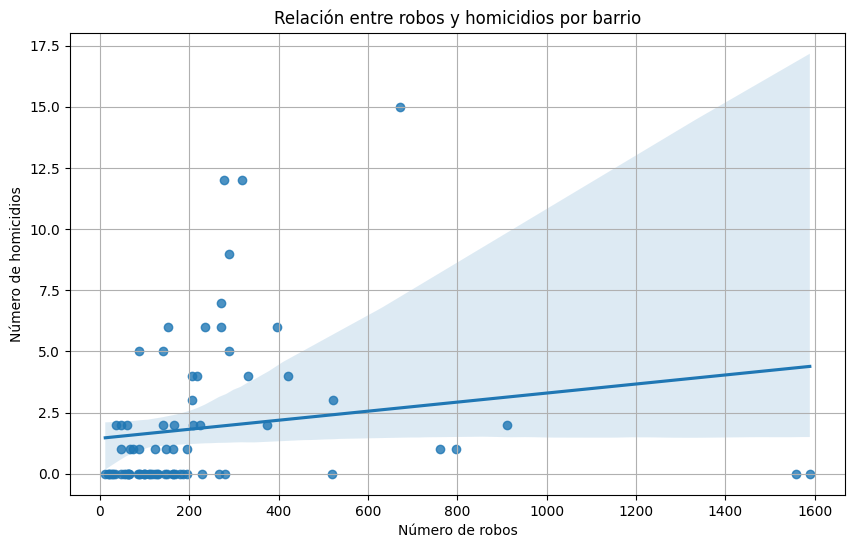

In [21]:
# crear una copia sin el total de la cudad
tabla_sint = tabla.drop(index='Total ciudad')

# graficar
plt.figure(figsize = (10,6))
sns.regplot(x = tabla_sint['robos'], y = tabla_sint['homicidios'])
plt.title("Relación entre robos y homicidios por barrio")
plt.xlabel("Número de robos")
plt.ylabel("Número de homicidios")
plt.grid(True)
plt.show()

La gráfica nos permit
e apreciar una relación lineal positiva entre la cantidad de robos y la cantidad de homicidios. Esto subraya la necesidad de encontrar densidades de crímenes con el objetivo de asignar eficientemente policías, cámaras, entre otros.

### 3. Distribución espacial del delito

#### 3.1 Distribución respecto al centro de la ciudad

Tomando como centro de la ciudad las coordenadas (-87.627800, 41.881998), estime funciones de densidad que muestren gráficamente el gradiente del total de robos, y homicidios, como función de la distancia al centro de la ciudad. Explique cómo midió las distancias incluyendo que medida de distancia utilizó. Para elegir el ancho de banda y la función de kernel más apropiados utilice validación cruzada usando todas las opciones posibles de kernel. Describa los resultados que obtiene.

In [30]:
chicago_geo.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [35]:
# PREGUNTA: debo cambiar de coordenadas a metros para sacar distancias?
from shapely.geometry import Point
# convertir de coordenadas a metros
chicago_geo['geometry'] = chicago.apply(lambda row: Point(row['lon'],
                                                          row['lat']), axis = 1)
gdf = gpd.GeoDataFrame(chicago_geo, geometry = 'geometry',
                       crs  ='EPSG:4326')  # WGS84

# proyectar a un sistema en metros (Chicago está en UTM zona 16N o EPSG:26971)
chicago_m = gdf.to_crs('EPSG:26971')

In [36]:
chicago_m.crs

<Projected CRS: EPSG:26971>
Name: NAD83 / Illinois East
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.27, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (meter)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [27]:
# coordenadas del centro
lon_centro = -87.627800
lat_centro = 41.881998

# distancia euclidiana aproximada
chicago_geo['distancia_al_centro'] = np.sqrt(
    (chicago['lat'] - lat_centro)**2 + (chicago['lon'] - lon_centro)**2
)

# Convertir a matriz 2D como requiere sklearn
vals = chicago_geo['distancia_al_centro'].values.reshape(-1, 1)

# Definir el rango de búsqueda de bandwidths
bandwidths = 10 ** np.linspace(-1, 1, 100)

# Grid search
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv = 10)

grid.fit(vals)

GridSearchCV(cv=10, estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.319926...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

In [28]:
best_bandwidth = grid.best_params_["bandwidth"]

print(f"Mejor ancho de banda: {best_bandwidth:.5f}")

Mejor ancho de banda: 0.10000


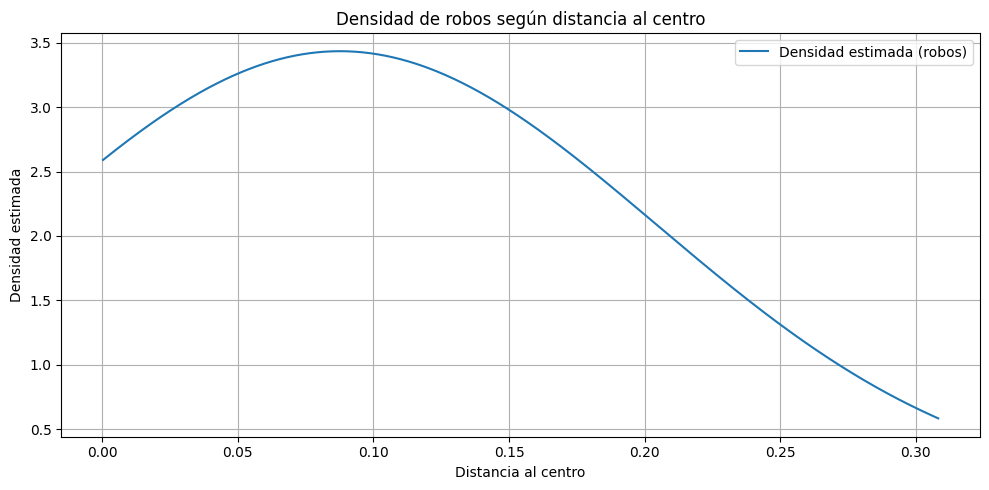

In [29]:
# usar el mejor modelo encontrado
kde = grid.best_estimator_

# crear puntos a lo largo del rango de distancias
x_plot = np.linspace(vals.min(), vals.max(), 1000).reshape(-1, 1)

# estimar la densidad
log_dens = kde.score_samples(x_plot)
dens = np.exp(log_dens)

# Graficar
plt.figure(figsize=(10,5))
plt.plot(x_plot, dens, label='Densidad estimada (robos)')
plt.title("Densidad de robos según distancia al centro")
plt.xlabel("Distancia al centro")
plt.ylabel("Densidad estimada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 3.2 Puntos calientes en la ciudad

Usando `statsmodels` implemente la estimación de densidad bivariada para el total de robos y el total de homicidios. Muestre los resultados usando curvas de nivel en una visualización interactiva. Compare los resultados de estimar usando los anchos de banda: `normal_reference` y `cv_ml`. Explique en que consisten ambas formas de estimar el ancho de banda. Comente sobre los puntos calientes encontrados bajo ambos métodos y su ubicación en la ciudad. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

## 4. Explicando la ubicación del delito

El objetivo de este punto es encontrar posibles correlaciones  entre el crimen y características de la ciudad. Para ello, utilice los datos de OpenStreetMap y explore si existe una correlación entre el porcentaje del área de la comunidad  dedicado a tiendas (`retail`)  y comercios (`commercial`) y el número total de robos y homicidios en esa comunidad. Ofrezca una explicación intuitiva de por qué cree que aparecen estas correlaciones. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)